In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from math import sqrt, pow
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
from scipy.spatial import ConvexHull


def getpathpoints(parent, n, g, centroids):
    path = [[], []]
    # print( "Edge \tWeight")
    for i in range(1, n):
        frames = np.linspace(0, 1, num=int(g[i][parent[i]]))
        for t in frames:
            x = centroids[parent[i]][0] + \
                (centroids[i][0]-centroids[parent[i]][0]) * t
            y = centroids[parent[i]][1] + \
                (centroids[i][1]-centroids[parent[i]][1]) * t
            path[0].append(x)
            path[1].append(y)
        # print (parent[i], "-", i, "\t", g[i][parent[i]])
    return path


def minKey(key, mstSet, n):
    min = float('inf')
    for v in range(n):
        if key[v] < min and mstSet[v] == False:
            min = key[v]
            min_index = v
    return min_index


def primMST(n, g):
    key = [float('inf')] * n
    parent = [None] * n
    key[0] = 0
    mstSet = [False] * n
    parent[0] = -1
    for _ in range(n):
        u = minKey(key, mstSet, n)
        mstSet[u] = True
        for v in range(n):
            if g[u][v] > 0 and mstSet[v] == False and key[v] > g[u][v]:
                key[v] = g[u][v]
                parent[v] = u
    return parent

# def get_sink_node_path():
#     y = [y for y in range(0,40)]
#     x = [(y/4)**2 for y in y]
#     return [x,y]


# def get_sink_node_path(centroids, n):
#     graph = creategraph(centroids, n)
#     # print(graph)
#     parent = primMST(n,graph)
#     # print(parent)
#     return getpathpoints(parent,n,graph,centroids)


def geteratepointsinbetween(p1,p2):
    frames = np.linspace(0, 1, num=int(get_distance(p1, p2)//3))
    path = [[], []]
    for t in frames:
        x = p1[0] + \
            (p2[0]- p1[0]) * t
        y = p1[1] + \
            (p2[1]- p1[1]) * t
        path[0].append(x)
        path[1].append(y)
    return path


def get_sink_node_path(X, n):
    x1, x2, y2, y1 = [10000000000, -1], [-1, -
                                         1], [-1, -1], [-1, 10000000000000]
    for i in X:
        if i[0] <= x1[0]:
            x1 = list(i)
        if i[0] >= x2[0]:
            x2 = list(i)
        if i[1] >= y2[1]:
            y2 = list(i)
        if i[1] <= y1[1]:
            y1 = list(i)
    x1[0] -= 3
    x2[0] += 3
    y2[1] += 3
    p1, p2 = [x1[0], (x1[1]+y1[1])//2], [x2[0], (x2[1]+y1[1])//2]
    if x1[0] == y2[0]:
        y2[0] += 1
    if y2[0] == x2[0]:
        y2[0] += 1

    listOfPoints = [x1, x2, y2]
    # print(listOfPoints)
    listOfPoints.sort()
    x_coOrdinates = []
    y_coOrdinates = []
    for i in listOfPoints:
        x_coOrdinates.append(i[0])
        y_coOrdinates.append(i[1])
    x_coOrdinates = np.array(x_coOrdinates)
    y_coOrdinates = np.array(y_coOrdinates)
    sinkNode_x = np.linspace(x_coOrdinates.min(), x_coOrdinates.max(), 50)
    spl = make_interp_spline(x_coOrdinates, y_coOrdinates, k=2)
    sinkNode_y = spl(sinkNode_x)
    for i in range(50):
        sinkNode_x[i] = round(sinkNode_x[i], 3)
        sinkNode_y[i] = round(sinkNode_y[i], 3)
    sinkNode_x = list(sinkNode_x)
    sinkNode_y = list(sinkNode_y)
    gen = geteratepointsinbetween([sinkNode_x[0],sinkNode_y[0]],p1)
    sinkNode_x = gen[0] + sinkNode_x
    sinkNode_y = gen[1] + sinkNode_y
    gen = geteratepointsinbetween([sinkNode_x[-1],sinkNode_y[-1]],p2)
    sinkNode_x = sinkNode_x + gen[0]
    sinkNode_y = sinkNode_y + gen[1]
    sinkNode_x.append(p2[0])
    sinkNode_y.append(p2[1])
    print("x: ", sinkNode_x)
    print("y: ", sinkNode_y)
    return [sinkNode_x, sinkNode_y]


def plot_silh(X):
    sil = []
    for i in range(2, 10):
        KM = KMeans(n_clusters=i, max_iter=500)
        KM.fit(X)
        lables = KM.labels_
        sil.append(silhouette_score(X, lables, metric='euclidean'))
    # plt.clf()
    # plt.plot(range(2,10),sil)
    # plt.draw()
    print(sil.index(max(sil))+2)
    print(sil)
    return sil.index(max(sil))+2


def get_distance(x, y):
    return sqrt(pow((x[0]-y[0]), 2) + pow((x[1]-y[1]), 2))


def get_energy_of_tramission(sink_node, cluster_node):
    data_agg_energy = 5 * 10 ** -9
    tx_fs_energy = 10 * 10 ** -12
    tx_energy = 50 * 10 ** -9
    distance = get_distance(sink_node, cluster_node)
    return (5000*(tx_energy+data_agg_energy)-(5000*tx_fs_energy*(distance**2)))


def get_optimal_node(sink_node, min_dist_cluster_no, cluster_matrix, energies):
    tx_energy = {}
    max_energy = -1
    for i in cluster_matrix[min_dist_cluster_no]:
        tx_energy[tuple(i)] = get_energy_of_tramission(sink_node, i)
        max_energy = max(max_energy, energies[tuple(i)])
    optimalNode = []
    min_tx_energy = 10000000000000000000
    for i in tx_energy:
        if energies[i] == max_energy:
            if min_tx_energy >= tx_energy[i]:
                optimalNode = list(i)
                min_tx_energy = tx_energy[i]
    energies[tuple(optimalNode)] -= min_tx_energy
    return optimalNode


def creategraph(centroids, n):
    g = []
    for i in range(n):
        k = []
        for j in range(n):
            if i == j:
                k.append(0)
            else:
                k.append(get_distance(centroids[i], centroids[j]))
        g.append(k)
    return g


In [3]:
!pip install celluloid

2
[0.6560042028272682, 0.6492068067360967, 0.5852513955637131, 0.56186964838538, 0.5511485637732397, 0.45255500575299745, 0.40661240383252634, 0.28195724219829377]
Clusters : [0 0 0 0 0 1 1 1 1 0 0 0 0 0]
Centroids : {0: (42.5, 5.599999999999994), 1: (48.75, 82.5)}
Redii's : {0: 32.67736219464478, 1: 54.15544755608617}
x:  [16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 17.776, 19.551, 21.327, 23.102, 24.878, 26.653, 28.429, 30.204, 31.98, 33.755, 35.531, 37.306, 39.082, 40.857, 42.633, 44.408, 46.184, 47.959, 49.735, 51.51, 53.286, 55.061, 56.837, 58.612, 60.388, 62.163, 63.939, 65.714, 67.49, 69.265, 71.041, 72.816, 74.592, 76.367, 78.143, 79.918, 81.694, 83.469, 85.245, 87.02, 88.796, 90.571, 92.347, 94.122, 95.898, 97.673, 99.449, 101.224, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103]
y:  [71.0, 67.5, 64.0, 60.5, 57.0, 53.5, 50.0, 46.5, 43.0, 39.5, 36.0, 71.0, 73.994, 76.887, 79.6

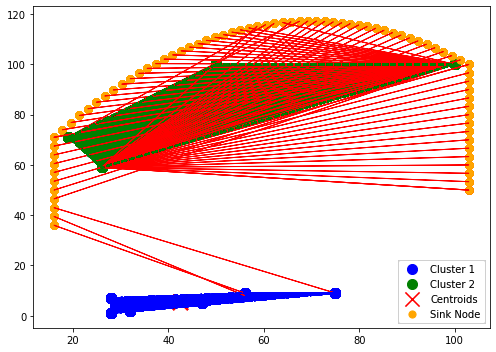

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from celluloid import Camera

col = ['blue', 'green', 'c', 'm', 'y', 'k', "violet", "indigo"]
X = np.array([[28, 7], [36, 5], [32, 2], [56, 8], [47, 5], [50,100], [100,100], [26,59], [19,71],
              [75, 9], [34, 4], [56, 9], [28, 1], [33, 6]])
ncluster = plot_silh(X)
kmeans = KMeans(n_clusters=ncluster, max_iter=500).fit(X)
y = kmeans.labels_
centroids = kmeans.cluster_centers_
print("Clusters :", y)
clusters_centroids = dict()
clusters_radii = dict()
for cluster in range(ncluster):
    clusters_centroids[cluster] = list(
        zip(centroids[:, 0], centroids[:, 1]))[cluster]
    clusters_radii[cluster] = max([np.linalg.norm(np.subtract(
        i, clusters_centroids[cluster])) for i in zip(X[y == cluster, 0], X[y == cluster, 1])])
print("Centroids :", clusters_centroids)
print("Redii's :", clusters_radii)

fig, ax = plt.subplots(1, figsize=(7, 5))

sink_node = get_sink_node_path(X, len(X))     # sink node creation


# print("Sink Node :\nX :",sink_node[0], "\nY :", sink_node[1])

def drawclusters():
    for i in range(ncluster):
        points = X[y == i]
        ax.scatter(points[:, 0], points[:, 1], s=100, c=col[i], label=f'Cluster {i + 1}')
        hull = ConvexHull(points)
        vert = np.append(hull.vertices, hull.vertices[0])  # close the polygon by appending the first point at the end
        ax.plot(points[vert, 0], points[vert, 1], '--', c=col[i])
        ax.fill(points[vert, 0], points[vert, 1], c=col[i], alpha=0.2)
    plt.scatter(centroids[:, 0], centroids[:, 1], s=200,
                c='red', label='Centroids', marker='x')
    plt.scatter(sink_node[0], sink_node[1], s=50,
                c='orange', label=f'Sink Node')


drawclusters()
plt.legend()
plt.tight_layout()
# plt.show()

camera = Camera(fig)


no_of_nodes = len(X)
energies = {}
for i in X:
    energies[tuple(i)] = 5
# print(energies)
cluster_matrix = [[] for i in range(ncluster)]
for i in range(no_of_nodes):
  cluster_matrix[y[i]].append(X[i])


for i in range(len(sink_node[0])):
  present_sink_node = [sink_node[0][i],sink_node[1][i]]
  min_dist = 10000000000000
  cluster_no = -1
  for j in range(ncluster):
    dist  = get_distance(present_sink_node, centroids[j])
    if min_dist>=dist:
      min_dist = dist
      cluster_no = j
  optimal_point = get_optimal_node(present_sink_node,cluster_no, cluster_matrix, energies)
#   print(present_sink_node, optimal_point, cluster_no)
  ax.arrow(present_sink_node[0], present_sink_node[1], optimal_point[0] - present_sink_node[0], optimal_point[1] - present_sink_node[1],width=0.02,color='red',head_length=0.0,head_width=0.0)
  ax.scatter(present_sink_node[0], present_sink_node[1], s=50, c='red')
  ax.scatter(optimal_point[0], optimal_point[1], s=50, c='red')

  camera.snap()
  drawclusters()

camera.snap()


In [6]:
from IPython.display import HTML
animation = camera.animate()

In [7]:
HTML(animation.to_html5_video())


CalledProcessError: ignored